In [1]:
# pip install --upgrade torch

Epoch [1/10], Loss: 153.1045
Epoch [2/10], Loss: 119.0050
Epoch [3/10], Loss: 113.8478
Epoch [4/10], Loss: 111.3862
Epoch [5/10], Loss: 109.9056
Epoch [6/10], Loss: 108.9600
Epoch [7/10], Loss: 108.2435
Epoch [8/10], Loss: 107.7307
Epoch [9/10], Loss: 107.2746
Epoch [10/10], Loss: 106.9194


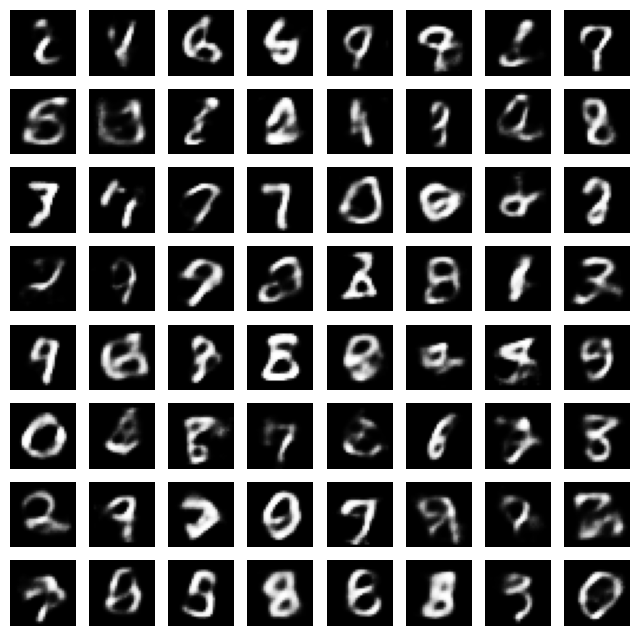

In [2]:
# Importowanie niezbędnych bibliotek PyTorch i NumPy
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

# Definicja prostego modelu VAE (Variational Autoencoder)


class VAE(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE, self).__init__()

        # Warstwa enkodera
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),  # Warstwa liniowa
            nn.ReLU(),  # Funkcja aktywacji ReLU
            # Warstwa liniowa z podwójną liczbą wyjść (parametry rozkładu: średnia i log-warjancja)
            nn.Linear(hidden_size, latent_size * 2)
        )

        # Warstwa dekodera
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),  # Warstwa liniowa
            nn.ReLU(),  # Funkcja aktywacji ReLU
            nn.Linear(hidden_size, input_size),  # Warstwa liniowa
            nn.Sigmoid()  # Funkcja aktywacji sigmoidalna na końcu, aby uzyskać wartości między 0 a 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)  # Obliczenie odchylenia standardowego
        eps = torch.randn_like(std)    # Losowa próbka z rozkładu normalnego
        return mu + eps * std  # Próbkowanie z rozkładu normalnego

    def forward(self, x):
        # Enkoder
        x = self.encoder(x)
        # Rozdzielenie wyników na średnią i log-warjancję
        mu, logvar = x.chunk(2, dim=1)
        # Próbkowanie z rozkładu normalnego
        z = self.reparameterize(mu, logvar)
        # Dekoder
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

# Definicja funkcji straty VAE (Variational Autoencoder)


def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(
        recon_x, x, reduction='sum')  # Binary Cross-Entropy
    # Kullback-Leibler Divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD  # Łączna funkcja straty


# Przygotowanie danych (MNIST jako przykład)
batch_size = 64
transform = transforms.Compose([transforms.ToTensor()])
train_loader = torch.utils.data.DataLoader(datasets.MNIST(root='./data', train=True, transform=transform, download=True),
                                           batch_size=batch_size, shuffle=True)

# Inicjalizacja modelu VAE
input_size = 784  # 28x28 pikseli
hidden_size = 256
latent_size = 20
vae = VAE(input_size, hidden_size, latent_size)

# Definicja optymalizatora (Adam)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Trenowanie modelu VAE przez określoną liczbę epok
num_epochs = 10
for epoch in range(num_epochs):
    vae.train()  # Przełączenie modelu w tryb treningu
    total_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        # Wymuszenie odpowiedniego kształtu danych wejściowych
        data = data.view(-1, input_size)
        optimizer.zero_grad()  # Wyzerowanie gradientów
        # Przekazanie danych przez model VAE
        recon_batch, mu, logvar = vae(data)
        # Obliczenie funkcji straty VAE
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()  # Wsteczna propagacja
        total_loss += loss.item()
        optimizer.step()  # Aktualizacja wag modelu
    print(
        f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader.dataset):.4f}')

# Generowanie próbek z modelu VAE
vae.eval()  # Przełączenie modelu w tryb ewaluacji
with torch.no_grad():
    z = torch.randn(64, latent_size)  # Losowe próbki z rozkładu normalnego
    generated_samples = vae.decoder(
        z).view(-1, 1, 28, 28)  # Generowanie próbek

# Wyświetlanie wygenerowanych próbek za pomocą biblioteki Matplotlib
plt.figure(figsize=(8, 8))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    # Wyświetlenie wygenerowanej próbki
    plt.imshow(generated_samples[i].squeeze(), cmap='gray')
    plt.axis('off')  # Wyłączenie osi
plt.show()  # Wyświetlenie wykresu z wygenerowanymi próbkami